# Comprehensive Statistical Analysis - ERP Amplitudes Across Alignment Conditions

## Statistical Approach

For the dependent variable (ERP amplitude), normality assumptions were tested using the Shapiro–Wilk test for each alignment condition (high, medium, low). When normality assumptions were met, a one-way ANOVA was performed to test the effect of alignment on ERP amplitudes, with eta-squared (η²) reported as effect size. For non-normally distributed data, the nonparametric Kruskal-Wallis test was used instead.

When the omnibus test indicated significant differences across conditions (p < 0.05), post hoc pairwise comparisons were conducted. For parametric analyses, independent samples t-tests were used with Bonferroni correction for multiple comparisons (α = 0.05/3 = 0.0167). Effect sizes were reported as Cohen's d. For nonparametric analyses, Mann-Whitney U tests served as post hoc comparisons, with rank-biserial correlation (r) as effect size measure.

All p-values are two-tailed, with α = 0.05 for the omnibus tests. Descriptive statistics (means, standard deviations, medians, and ranges) and visualizations (box plots, violin plots, and bar charts with error bars) accompany all inferential results to aid interpretation.

**Study Design:** Between-subjects design with independent participants in each alignment condition (high: n=17, medium: n=16, low: n=15).

**Dependent Variable:** P300 mean amplitude (µV) at centro-parietal electrodes (Cz, CPz, Pz) within the 300-500ms time window post-stimulus.

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mne

# Statistical tests
from scipy import stats
from scipy.stats import shapiro, friedmanchisquare, wilcoxon, kruskal, mannwhitneyu
from scipy.stats import f_oneway, ttest_ind  # for parametric between-subjects
import itertools

# Configure plotting
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

print("="*100)
print("COMPREHENSIVE STATISTICAL ANALYSIS - ERP AMPLITUDES")
print("="*100)
print("\n✓ Libraries loaded successfully")

COMPREHENSIVE STATISTICAL ANALYSIS - ERP AMPLITUDES

✓ Libraries loaded successfully


## 1. Load ERP Data from Preprocessed Files

**Analysis Focus:** P300 component (300-500ms, centro-parietal electrodes: Cz, CPz, Pz)

In [2]:
# Load individual session ERPs
preprocessed_dir = Path('./preprocessed')

# P300 parameters
p300_electrodes = ['Cz', 'CPz', 'Pz']  # Centro-parietal ROI
p300_tmin = 0.300  # 300ms post-stimulus
p300_tmax = 0.500  # 500ms post-stimulus

# Data structure: list of dicts
data_records = []

conditions = ['high', 'medium', 'low']
condition_labels = {'high': 'High', 'medium': 'Medium', 'low': 'Low'}

print("\n" + "="*100)
print(f"P300 ANALYSIS PARAMETERS")
print("="*100)
print(f"Time window: {p300_tmin*1000:.0f}-{p300_tmax*1000:.0f} ms")
print(f"Electrodes: {', '.join(p300_electrodes)}")
print(f"Measure: Mean amplitude across electrodes and time window")
print("="*100)

print("\nLoading ERP data from preprocessed files...\n")

for condition in conditions:
    files = sorted(preprocessed_dir.glob(f'session_*-evoked-{condition}-ave.fif'))
    print(f"{condition_labels[condition]:8s} alignment: {len(files)} sessions")
    
    for sess_file in files:
        # Parse session ID
        filename = sess_file.name
        sess_id_str = filename.split('-')[0].replace('session_', '')
        
        try:
            sess_id = int(sess_id_str)
            evoked = mne.read_evokeds(str(sess_file), verbose=False)[0]
            
            # Get time indices for P300 window
            times = evoked.times
            time_mask = (times >= p300_tmin) & (times <= p300_tmax)
            
            # Extract P300 amplitude: mean across electrodes and time window
            p300_amplitudes = []
            for ch_name in p300_electrodes:
                if ch_name in evoked.ch_names:
                    ch_idx = evoked.ch_names.index(ch_name)
                    # Mean amplitude in time window (convert to µV)
                    ch_amplitude = np.mean(evoked.data[ch_idx, time_mask]) * 1e6
                    p300_amplitudes.append(ch_amplitude)
            
            # Average across electrodes
            if len(p300_amplitudes) > 0:
                amplitude = np.mean(p300_amplitudes)
                
                # Store record
                data_records.append({
                    'participant': sess_id,
                    'condition': condition_labels[condition],
                    'amplitude': amplitude,
                    'n_electrodes': len(p300_amplitudes)
                })
            else:
                print(f"  ⚠️ Session {sess_id}: No P300 electrodes found")
                
        except Exception as e:
            print(f"  ⚠️ Error loading session {sess_id}: {str(e)[:80]}")

# Create DataFrame
df = pd.DataFrame(data_records)

print(f"\n✓ Loaded {len(df)} total observations")
print(f"\nData shape: {df.shape}")

# Check electrode coverage
if 'n_electrodes' in df.columns:
    print(f"\nElectrode coverage: {df['n_electrodes'].unique()} electrodes per session")

print(f"\nFirst few rows:")
print(df.head(10))

# Summary by condition
print(f"\n{'='*100}")
print("SAMPLE SIZES PER CONDITION")
print(f"{'='*100}")
print(df.groupby('condition').size())

# Descriptive preview
print(f"\n{'='*100}")
print("P300 AMPLITUDE PREVIEW (µV)")
print(f"{'='*100}")
for cond in ['High', 'Medium', 'Low']:
    cond_data = df[df['condition'] == cond]['amplitude']
    if len(cond_data) > 0:
        print(f"{cond:8s}: M = {cond_data.mean():6.2f} µV, SD = {cond_data.std():5.2f} µV, n = {len(cond_data)}")
print("="*100)


P300 ANALYSIS PARAMETERS
Time window: 300-500 ms
Electrodes: Cz, CPz, Pz
Measure: Mean amplitude across electrodes and time window

Loading ERP data from preprocessed files...

High     alignment: 17 sessions
Medium   alignment: 16 sessions
Medium   alignment: 16 sessions
Low      alignment: 15 sessions
Low      alignment: 15 sessions

✓ Loaded 48 total observations

Data shape: (48, 4)

Electrode coverage: [3] electrodes per session

First few rows:
   participant condition     amplitude  n_electrodes
0            0      High -1.095491e+00             3
1            2      High  5.751099e-01             3
2            5      High  3.457770e-01             3
3            6      High -2.139182e+00             3
4            7      High  9.036942e-01             3
5            8      High -8.157897e-02             3
6            9      High  1.668320e+00             3
7           10      High -3.920982e-10             3
8           11      High -2.678816e-11             3
9           12

## 2. Automated Statistical Analysis Pipeline

For each dependent variable (here: ERP amplitude):
1. Test normality (Shapiro-Wilk)
2. Choose parametric vs non-parametric test
3. Run main test (One-way ANOVA or Kruskal-Wallis)
4. Post-hoc pairwise comparisons
5. Calculate effect sizes
6. Report descriptive statistics

In [3]:
# Dependent variable to analyze
dv = 'amplitude'

print("="*100)
print(f"STATISTICAL ANALYSIS: P300 AMPLITUDE")
print(f"Time window: 300-500ms | Electrodes: Cz, CPz, Pz")
print("="*100)

# Conditions
conditions_list = ['High', 'Medium', 'Low']

# ==============================
# 2.1 Shapiro-Wilk Test for Normality
# ==============================
print("\n" + "="*100)
print("STEP 1: NORMALITY TESTING (Shapiro-Wilk)")
print("="*100)

normal = True
normality_results = []

for cond in conditions_list:
    vals = df[df['condition'] == cond][dv].values
    
    if len(vals) >= 3:
        stat, p = shapiro(vals)
        is_normal = p > 0.05 # null hypothesis: data is normally distributed
        
        normality_results.append({
            'Condition': cond,
            'W': stat,
            'p-value': p,
            'Normal': 'Yes' if is_normal else 'No'
        })
        
        result_str = "✓ NORMAL" if is_normal else "✗ NOT NORMAL"
        print(f"{cond:8s} (n={len(vals):2d}): W={stat:.4f}, p={p:.4f} → {result_str}")
        
        if not is_normal:
            normal = False
    else:
        print(f"{cond:8s} (n={len(vals):2d}): ⚠️ Insufficient data for Shapiro-Wilk test")
        normal = False

df_normality = pd.DataFrame(normality_results)

print(f"\n{'='*100}")
if normal:
    print("✓ ALL CONDITIONS NORMAL → Use PARAMETRIC tests (One-way ANOVA)")
else:
    print("✗ AT LEAST ONE CONDITION NON-NORMAL → Use NON-PARAMETRIC tests (Kruskal-Wallis)")
print(f"{'='*100}")

STATISTICAL ANALYSIS: P300 AMPLITUDE
Time window: 300-500ms | Electrodes: Cz, CPz, Pz

STEP 1: NORMALITY TESTING (Shapiro-Wilk)
High     (n=17): W=0.9083, p=0.0935 → ✓ NORMAL
Medium   (n=16): W=0.5859, p=0.0000 → ✗ NOT NORMAL
Low      (n=15): W=0.5214, p=0.0000 → ✗ NOT NORMAL

✗ AT LEAST ONE CONDITION NON-NORMAL → Use NON-PARAMETRIC tests (Kruskal-Wallis)


## 3. Main Statistical Test

In [4]:
# Prepare data for tests
high_vals = df[df['condition'] == 'High'][dv].values
medium_vals = df[df['condition'] == 'Medium'][dv].values
low_vals = df[df['condition'] == 'Low'][dv].values

print("\n" + "="*100)
print("STEP 2: MAIN STATISTICAL TEST")
print("="*100)

# ==============================
# 3.1 Choose Test Based on Normality
# ==============================
if normal:
    print("\n→ Running ONE-WAY ANOVA (Parametric)\n")
    
    # One-way ANOVA for independent samples
    f_stat, p_val = f_oneway(high_vals, medium_vals, low_vals)
    
    print(f"One-Way ANOVA Results:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_val:.6f}")
    
    if p_val < 0.05:
        print(f"  ✓ SIGNIFICANT: Conditions differ significantly (p < 0.05)")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant difference (p ≥ 0.05)")
    
    # Calculate eta-squared (effect size)
    grand_mean = np.mean(np.concatenate([high_vals, medium_vals, low_vals]))
    ss_between = len(high_vals)*(np.mean(high_vals)-grand_mean)**2 + \
                 len(medium_vals)*(np.mean(medium_vals)-grand_mean)**2 + \
                 len(low_vals)*(np.mean(low_vals)-grand_mean)**2
    ss_total = np.sum((np.concatenate([high_vals, medium_vals, low_vals]) - grand_mean)**2)
    eta_squared = ss_between / ss_total
    print(f"  η² (eta-squared): {eta_squared:.4f}")
    
else:
    print("\n→ Running KRUSKAL-WALLIS TEST (Non-parametric)\n")
    
    # Kruskal-Wallis test for independent samples
    h_stat, p_val = kruskal(high_vals, medium_vals, low_vals)
    
    print(f"Kruskal-Wallis Test Results:")
    print(f"  H-statistic: {h_stat:.4f}") #test size 
    print(f"  p-value: {p_val:.6f}")
    
    if p_val < 0.05:
        print(f"  ✓ SIGNIFICANT: Conditions differ significantly (p < 0.05)")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant difference (p ≥ 0.05)")
    
    # Calculate epsilon-squared (effect size for Kruskal-Wallis)
    n_total = len(high_vals) + len(medium_vals) + len(low_vals)
    epsilon_squared = (h_stat - 2) / (n_total - 3)
    print(f"  ε² (epsilon-squared): {epsilon_squared:.4f}")


STEP 2: MAIN STATISTICAL TEST

→ Running KRUSKAL-WALLIS TEST (Non-parametric)

Kruskal-Wallis Test Results:
  H-statistic: 1.0347
  p-value: 0.596100
  ✗ NOT SIGNIFICANT: No significant difference (p ≥ 0.05)
  ε² (epsilon-squared): -0.0215


## 4. Post-Hoc Pairwise Comparisons

Only performed if main test is significant (p < 0.05)

In [5]:
print("\n" + "="*100)
print("STEP 3: POST-HOC PAIRWISE COMPARISONS")
print("="*100)

# Bonferroni correction
alpha_bonferroni = 0.05 / 3
print(f"\nBonferroni correction: α = 0.05 / 3 = {alpha_bonferroni:.4f}\n")

posthoc_results = []

if p_val < 0.05:  # Only if main test is significant
    print("Main test is SIGNIFICANT → Running post-hoc tests\n")
    
    if normal:
        print("→ Using INDEPENDENT T-TESTS (parametric)\n")
        
        # High vs Medium
        t_stat, p_hm = ttest_ind(high_vals, medium_vals)
        cohens_d_hm = (np.mean(high_vals) - np.mean(medium_vals)) / \
                      np.sqrt((np.var(high_vals, ddof=1) + np.var(medium_vals, ddof=1)) / 2)
        sig_hm = "✓ SIGNIFICANT" if p_hm < alpha_bonferroni else "✗ Not significant"
        print(f"High vs Medium:")
        print(f"  t={t_stat:.4f}, p={p_hm:.6f}, d={cohens_d_hm:.4f} → {sig_hm}")
        posthoc_results.append({'Comparison': 'High vs Medium', 'Statistic': t_stat, 
                               'p-value': p_hm, 'Effect_Size': cohens_d_hm, 
                               'Significant': p_hm < alpha_bonferroni})
        
        # High vs Low
        t_stat, p_hl = ttest_ind(high_vals, low_vals)
        cohens_d_hl = (np.mean(high_vals) - np.mean(low_vals)) / \
                      np.sqrt((np.var(high_vals, ddof=1) + np.var(low_vals, ddof=1)) / 2)
        sig_hl = "✓ SIGNIFICANT" if p_hl < alpha_bonferroni else "✗ Not significant"
        print(f"\nHigh vs Low:")
        print(f"  t={t_stat:.4f}, p={p_hl:.6f}, d={cohens_d_hl:.4f} → {sig_hl}")
        posthoc_results.append({'Comparison': 'High vs Low', 'Statistic': t_stat, 
                               'p-value': p_hl, 'Effect_Size': cohens_d_hl, 
                               'Significant': p_hl < alpha_bonferroni})
        
        # Medium vs Low
        t_stat, p_ml = ttest_ind(medium_vals, low_vals)
        cohens_d_ml = (np.mean(medium_vals) - np.mean(low_vals)) / \
                      np.sqrt((np.var(medium_vals, ddof=1) + np.var(low_vals, ddof=1)) / 2)
        sig_ml = "✓ SIGNIFICANT" if p_ml < alpha_bonferroni else "✗ Not significant"
        print(f"\nMedium vs Low:")
        print(f"  t={t_stat:.4f}, p={p_ml:.6f}, d={cohens_d_ml:.4f} → {sig_ml}")
        posthoc_results.append({'Comparison': 'Medium vs Low', 'Statistic': t_stat, 
                               'p-value': p_ml, 'Effect_Size': cohens_d_ml, 
                               'Significant': p_ml < alpha_bonferroni})
        
    else:
        print("→ Using MANN-WHITNEY U TESTS (non-parametric)\n")
        
        # High vs Medium
        u_stat, p_hm = mannwhitneyu(high_vals, medium_vals, alternative='two-sided')
        r_hm = 1 - (2*u_stat) / (len(high_vals) * len(medium_vals))  # rank-biserial
        sig_hm = "✓ SIGNIFICANT" if p_hm < alpha_bonferroni else "✗ Not significant"
        print(f"High vs Medium:")
        print(f"  U={u_stat:.4f}, p={p_hm:.6f}, r={r_hm:.4f} → {sig_hm}")
        posthoc_results.append({'Comparison': 'High vs Medium', 'Statistic': u_stat, 
                               'p-value': p_hm, 'Effect_Size': r_hm, 
                               'Significant': p_hm < alpha_bonferroni})
        
        # High vs Low
        u_stat, p_hl = mannwhitneyu(high_vals, low_vals, alternative='two-sided')
        r_hl = 1 - (2*u_stat) / (len(high_vals) * len(low_vals))
        sig_hl = "✓ SIGNIFICANT" if p_hl < alpha_bonferroni else "✗ Not significant"
        print(f"\nHigh vs Low:")
        print(f"  U={u_stat:.4f}, p={p_hl:.6f}, r={r_hl:.4f} → {sig_hl}")
        posthoc_results.append({'Comparison': 'High vs Low', 'Statistic': u_stat, 
                               'p-value': p_hl, 'Effect_Size': r_hl, 
                               'Significant': p_hl < alpha_bonferroni})
        
        # Medium vs Low
        u_stat, p_ml = mannwhitneyu(medium_vals, low_vals, alternative='two-sided')
        r_ml = 1 - (2*u_stat) / (len(medium_vals) * len(low_vals))
        sig_ml = "✓ SIGNIFICANT" if p_ml < alpha_bonferroni else "✗ Not significant"
        print(f"\nMedium vs Low:")
        print(f"  U={u_stat:.4f}, p={p_ml:.6f}, r={r_ml:.4f} → {sig_ml}")
        posthoc_results.append({'Comparison': 'Medium vs Low', 'Statistic': u_stat, 
                               'p-value': p_ml, 'Effect_Size': r_ml, 
                               'Significant': p_ml < alpha_bonferroni})
    
    # Summary table
    df_posthoc = pd.DataFrame(posthoc_results)
    print(f"\n{'='*100}")
    print("POST-HOC SUMMARY TABLE")
    print(f"{'='*100}")
    print(df_posthoc.to_string(index=False))
    
else:
    print("Main test is NOT SIGNIFICANT → Skipping post-hoc tests")


STEP 3: POST-HOC PAIRWISE COMPARISONS

Bonferroni correction: α = 0.05 / 3 = 0.0167

Main test is NOT SIGNIFICANT → Skipping post-hoc tests


## 5. Descriptive Statistics

In [6]:
print("\n" + "="*100)
print("STEP 4: DESCRIPTIVE STATISTICS")
print("="*100 + "\n")

descriptive_stats = []

for cond in conditions_list:
    vals = df[df['condition'] == cond][dv].values
    
    if len(vals) > 0:
        descriptive_stats.append({
            'Condition': cond,
            'N': len(vals),
            'Mean': np.mean(vals),
            'SD': np.std(vals, ddof=1),
            'Median': np.median(vals),
            'Min': np.min(vals),
            'Max': np.max(vals),
            'SEM': np.std(vals, ddof=1) / np.sqrt(len(vals))
        })
        
        print(f"{cond:8s} (n={len(vals):2d}):")
        print(f"  Mean ± SD: {np.mean(vals):.2f} ± {np.std(vals, ddof=1):.2f} µV")
        print(f"  Median: {np.median(vals):.2f} µV")
        print(f"  Range: [{np.min(vals):.2f}, {np.max(vals):.2f}] µV")
        print()

df_descriptive = pd.DataFrame(descriptive_stats)

print(f"{'='*100}")
print("DESCRIPTIVE STATISTICS TABLE")
print(f"{'='*100}")
print(df_descriptive.to_string(index=False))


STEP 4: DESCRIPTIVE STATISTICS

High     (n=17):
  Mean ± SD: 0.02 ± 0.82 µV
  Median: -0.00 µV
  Range: [-2.14, 1.67] µV

Medium   (n=16):
  Mean ± SD: -0.20 ± 1.10 µV
  Median: 0.00 µV
  Range: [-4.10, 0.65] µV

Low      (n=15):
  Mean ± SD: 0.39 ± 1.17 µV
  Median: 0.04 µV
  Range: [-0.41, 4.49] µV

DESCRIPTIVE STATISTICS TABLE
Condition  N      Mean       SD        Median       Min      Max      SEM
     High 17  0.019500 0.817288 -2.678816e-11 -2.139182 1.668320 0.198222
   Medium 16 -0.204508 1.098389  1.227823e-10 -4.097835 0.650325 0.274597
      Low 15  0.391693 1.174697  3.841601e-02 -0.407549 4.487141 0.303306


## 6. Save Results to CSV

In [7]:
import os

# Create results directory if needed
os.makedirs('./results', exist_ok=True)

# Save normality test results
if len(normality_results) > 0:
    df_normality.to_csv('./results/comprehensive_normality_results.csv', index=False)
    print("✓ Normality results saved to: ./results/comprehensive_normality_results.csv")

# Save post-hoc results
if len(posthoc_results) > 0:
    df_posthoc.to_csv('./results/comprehensive_posthoc_results.csv', index=False)
    print("✓ Post-hoc results saved to: ./results/comprehensive_posthoc_results.csv")

# Save descriptive statistics
if len(descriptive_stats) > 0:
    df_descriptive.to_csv('./results/comprehensive_descriptive_stats.csv', index=False)
    print("✓ Descriptive statistics saved to: ./results/comprehensive_descriptive_stats.csv")

print("\n✓ All results saved successfully!")

✓ Normality results saved to: ./results/comprehensive_normality_results.csv
✓ Descriptive statistics saved to: ./results/comprehensive_descriptive_stats.csv

✓ All results saved successfully!


## 7. Visualization

C:\Users\kimbe\AppData\Local\Temp\ipykernel_23984\897724811.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=conditions_list, patch_artist=True, widths=0.6)


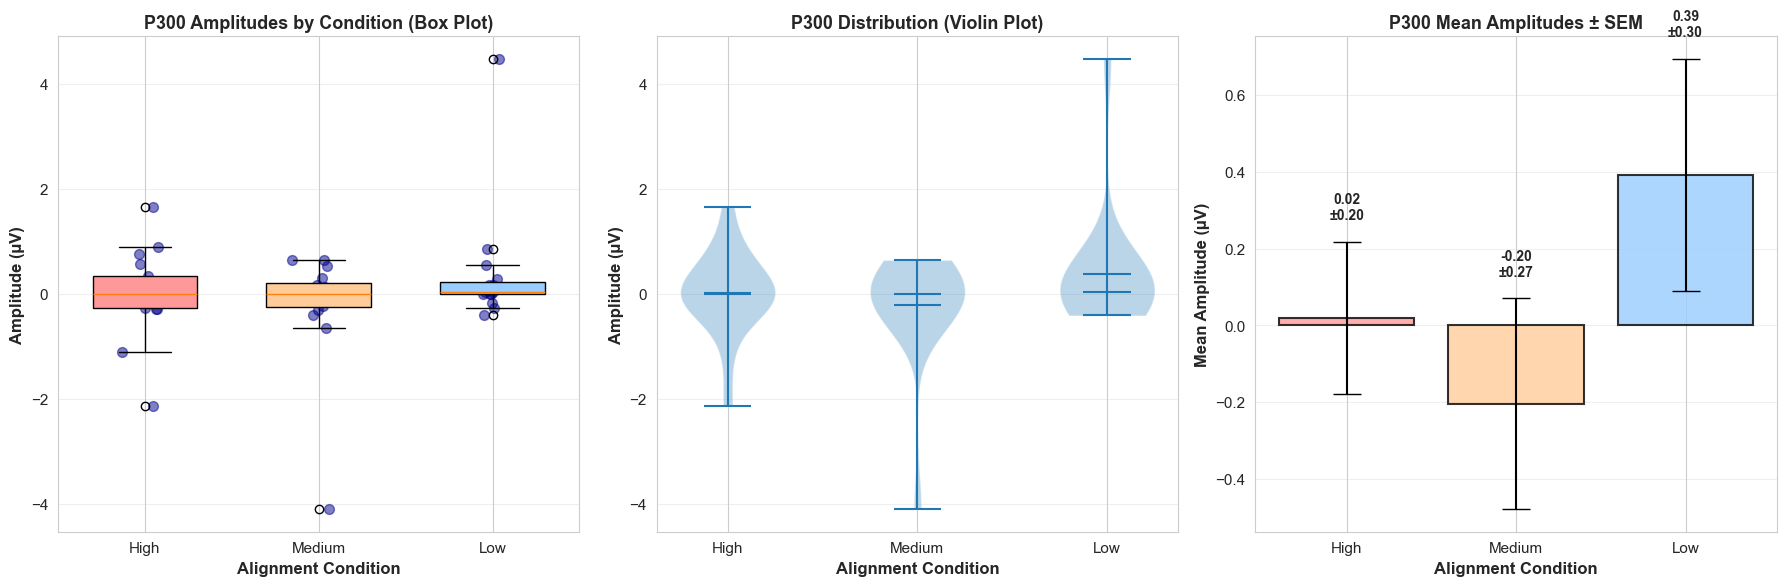


✓ Visualization saved to: ./results/comprehensive_analysis_plots.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Box plot with individual points
ax = axes[0]
data_for_plot = [high_vals, medium_vals, low_vals]
bp = ax.boxplot(data_for_plot, labels=conditions_list, patch_artist=True, widths=0.6)

colors = ['#ff9999', '#ffcc99', '#99ccff']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points
for i, (vals, cond) in enumerate(zip(data_for_plot, conditions_list), 1):
    y = vals
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.5, s=50, color='darkblue')

ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_xlabel('Alignment Condition', fontsize=12, fontweight='bold')
ax.set_title('P300 Amplitudes by Condition (Box Plot)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Violin plot
ax = axes[1]
parts = ax.violinplot(data_for_plot, positions=[1, 2, 3], showmeans=True, showmedians=True)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(conditions_list)
ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_xlabel('Alignment Condition', fontsize=12, fontweight='bold')
ax.set_title('P300 Distribution (Violin Plot)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Bar plot with error bars (Mean ± SEM)
ax = axes[2]
means = [np.mean(vals) for vals in data_for_plot]
sems = [np.std(vals, ddof=1)/np.sqrt(len(vals)) for vals in data_for_plot]

x_pos = np.arange(len(conditions_list))
bars = ax.bar(x_pos, means, yerr=sems, capsize=10, 
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_ylabel('Mean Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_xlabel('Alignment Condition', fontsize=12, fontweight='bold')
ax.set_title('P300 Mean Amplitudes ± SEM', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions_list)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + sem + 0.05,
           f'{mean:.2f}\n±{sem:.2f}',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./results/comprehensive_analysis_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: ./results/comprehensive_analysis_plots.png")

## 8. Summary Report

In [9]:
print("\n" + "="*100)
print("FINAL SUMMARY REPORT")
print("="*100)

print(f"\n📊 SAMPLE SIZES:")
for cond in conditions_list:
    n = len(df[df['condition'] == cond])
    print(f"  {cond}: n = {n}")

print(f"\n📈 DESCRIPTIVE STATISTICS:")
for cond in conditions_list:
    vals = df[df['condition'] == cond][dv].values
    print(f"  {cond}: M = {np.mean(vals):.2f} µV, SD = {np.std(vals, ddof=1):.2f} µV")

print(f"\n🔬 NORMALITY:")
if normal:
    print("  ✓ All conditions normally distributed (parametric tests used)")
else:
    print("  ✗ At least one condition non-normal (non-parametric tests used)")

print(f"\n📉 MAIN TEST:")
if normal:
    print(f"  One-Way ANOVA: F = {f_stat:.4f}, p = {p_val:.6f}")
else:
    print(f"  Kruskal-Wallis: H = {h_stat:.4f}, p = {p_val:.6f}")

if p_val < 0.05:
    print("  ✓ SIGNIFICANT difference across conditions")
else:
    print("  ✗ NO significant difference across conditions")

if p_val < 0.05 and len(posthoc_results) > 0:
    print(f"\n🔍 POST-HOC COMPARISONS (Bonferroni α = {alpha_bonferroni:.4f}):")
    for result in posthoc_results:
        sig_str = "✓ SIGNIFICANT" if result['Significant'] else "✗ Not significant"
        print(f"  {result['Comparison']}: p = {result['p-value']:.6f} → {sig_str}")

print(f"\n{'='*100}")
print("✓ Analysis complete!")
print(f"{'='*100}")


FINAL SUMMARY REPORT

📊 SAMPLE SIZES:
  High: n = 17
  Medium: n = 16
  Low: n = 15

📈 DESCRIPTIVE STATISTICS:
  High: M = 0.02 µV, SD = 0.82 µV
  Medium: M = -0.20 µV, SD = 1.10 µV
  Low: M = 0.39 µV, SD = 1.17 µV

🔬 NORMALITY:
  ✗ At least one condition non-normal (non-parametric tests used)

📉 MAIN TEST:
  Kruskal-Wallis: H = 1.0347, p = 0.596100
  ✗ NO significant difference across conditions

✓ Analysis complete!
